In [18]:
# create a four item DataFrame
s = Series([1, 2, 3, 4])
print(s)
print(s[[1, 3]])

s = Series([1, 2, 3, 4],
index = ['a', 'b', 'c', 'd'])

s['a']
s.index
dates = pd.date_range('2014-07-01', '2014-07-06')
dates

0    1
1    2
2    3
3    4
dtype: int64
1    2
3    4
dtype: int64


DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# create a Series with values (representing temperatures)
# for each date in the index
temps1 = Series([80, 82, 85, 90, 83, 87],
index = dates)

temps2 = Series([70, 75, 69, 83, 79, 77],
index = dates)

print(temps1)
print(temps2)
temps1-temps2

temps_df = DataFrame(
{'Missoula': temps1,
'Philadelphia': temps2})
temps_df
temp_diffs = temps_df.Missoula - temps_df.Philadelphia

# add a column to temp_df that contains the difference in temps
temps_df['Difference'] = temp_diffs
temps_df

print(temps_df)

print()
print(temps_df.iloc[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:111: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: covariance is not positive-semidefinite.


[-931.457086088967, -496.4885237174033, -459.33914688320544, -452.0181991849052, -451.17650595193993, -448.73153830461274, -428.2118874853735, -373.7319639913657, -296.3881402933474, -184.92988425156489, -145.127176077964, -143.94873831421, -143.94886545905217, -143.9488655473433]


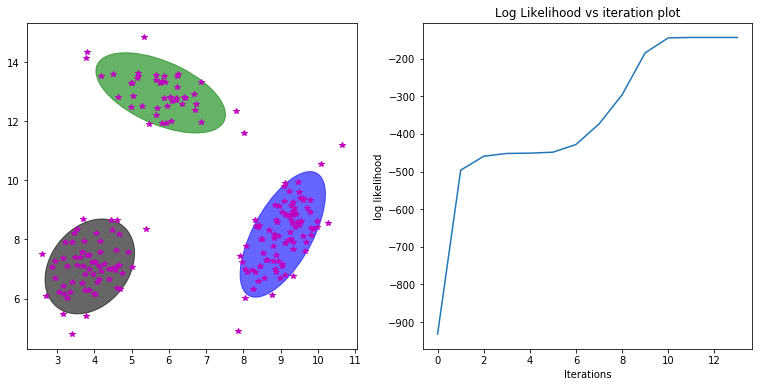

[2.20783559e-036 1.00000000e+000 1.55285737e-109]


ValueError: could not convert string to float: 'PAYMENT'

In [4]:
import numpy as np
    
class GMM:
    
    def __init__(self, k = 3, eps = 0.0001):
        self.k = k ## number of clusters
        self.eps = eps ## threshold to stop `epsilon`
        
        # All parameters from fitting/learning are kept in a named tuple
        from collections import namedtuple
    
    def fit_EM(self, X, max_iters = 1000):
        
        # n = number of data-points, d = dimension of data points        
        n, d = X.shape
        
        # randomly choose the starting centroids/means 
        ## as 3 of the points from datasets        
        mu = X[np.random.choice(n, self.k, False), :]
        
        # initialize the covariance matrices for each gaussians
        Sigma= [np.eye(d)] * self.k
        
        # initialize the probabilities/weights for each gaussians
        w = [1./self.k] * self.k
        
        # responsibility matrix is initialized to all zeros
        # we have responsibility for each of n points for eack of k gaussians
        R = np.zeros((n, self.k))
        
        ### log_likelihoods
        log_likelihoods = []
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 ** (2 * np.pi) ** (-X.shape[1]/2.) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
                        
        # Iterate till max_iters iterations        
        while len(log_likelihoods) < max_iters:
            
            # E - Step
            
            ## Vectorized implementation of e-step equation to calculate the 
            ## membership for each of k -gaussians
            for k in range(self.k):
                R[:, k] = w[k] * P(mu[k], Sigma[k])

            ### Likelihood computation
            log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
            
            log_likelihoods.append(log_likelihood)
            
            ## Normalize so that the responsibility matrix is row stochastic
            R = (R.T / np.sum(R, axis = 1)).T
            
            ## The number of datapoints belonging to each gaussian            
            N_ks = np.sum(R, axis = 0)
            
            
            # M Step
            ## calculate the new mean and covariance for each gaussian by 
            ## utilizing the new responsibilities
            for k in range(self.k):
                
                ## means
                mu[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
                x_mu = np.matrix(X - mu[k])
                
                ## covariances
                Sigma[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
                
                ## and finally the probabilities
                w[k] = 1. / n * N_ks[k]
            # check for onvergence
            if len(log_likelihoods) < 2 : continue
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps: break
        
        ## bind all results together
        from collections import namedtuple
        self.params = namedtuple('params', ['mu', 'Sigma', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mu = mu
        self.params.Sigma = Sigma
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)       
        
        return self.params
    
    def plot_log_likelihood(self):
        import pylab as plt
        plt.plot(self.params.log_likelihoods)
        plt.title('Log Likelihood vs iteration plot')
        plt.xlabel('Iterations')
        plt.ylabel('log likelihood')
        plt.show()
    
    def predict(self, x):
        p = lambda mu, s : np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu , \
                        np.dot(np.linalg.inv(s) , x - mu)))
        probs = np.array([w * p(mu, s) for mu, s, w in \
            zip(self.params.mu, self.params.Sigma, self.params.w)])
        return probs/np.sum(probs)
        
        
def demo_2d():
    
    # Load data
    #X = np.genfromtxt('data1.csv', delimiter=',')
    ### generate the random data     
    np.random.seed(3)
    m1, cov1 = [9, 8], [[.5, 1], [.25, 1]] ## first gaussian
    data1 = np.random.multivariate_normal(m1, cov1, 90)
    
    m2, cov2 = [6, 13], [[.5, -.5], [-.5, .1]] ## second gaussian
    data2 = np.random.multivariate_normal(m2, cov2, 45)
    
    m3, cov3 = [4, 7], [[0.25, 0.5], [-0.1, 0.5]] ## third gaussian
    data3 = np.random.multivariate_normal(m3, cov3, 65)
    X = np.vstack((data1,np.vstack((data2,data3))))
    np.random.shuffle(X)
#    np.savetxt('sample.csv', X, fmt = "%.4f",  delimiter = ",")
    ####
    gmm = GMM(3, 0.000001)
    params = gmm.fit_EM(X, max_iters= 100)
    print(params.log_likelihoods)
    import pylab as plt    
    from matplotlib.patches import Ellipse
    
    def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:,order]
    
        if ax is None:
            ax = plt.gca()
    
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
        # Width and height are "full" widths, not radius
        width, height = 2 * nstd * np.sqrt(abs(vals))
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
        ax.add_artist(ellip)
        return ellip    
    
    def show(X, mu, cov):

        plt.cla()
        K = len(mu) # number of clusters
        colors = ['b', 'k', 'g', 'c', 'm', 'y', 'r']
        plt.plot(X.T[0], X.T[1], 'm*')
        for k in range(K):
          plot_ellipse(mu[k], cov[k],  alpha=0.6, color = colors[k % len(colors)])  

    
    fig = plt.figure(figsize = (13, 6))
    fig.add_subplot(121)
    show(X, params.mu, params.Sigma)
    fig.add_subplot(122)
    plt.plot(np.array(params.log_likelihoods))
    plt.title('Log Likelihood vs iteration plot')
    plt.xlabel('Iterations')
    plt.ylabel('log likelihood')
    plt.show()
    print(gmm.predict(np.array([1, 2])))
    
    

demo_2d()

k = 3
eps = 0.0001    
max_iters = 1000
    
X = np.loadtxt('fraud_cc.csv', delimiter=',', skiprows=1)
gmm = GMM(k, eps)
params = gmm.fit_EM(X, max_iters)
print(params.log_likelihoods)
gmm.plot_log_likelihood()
print(gmm.predict(np.array([1, 2])))